In [ ]:
# ArUco Marker Ï¢åÌëú Ï∂îÏ†ï

import cv2
import numpy as np
import cv2.aruco as aruco
from IPython.display import clear_output
from collections import deque

cap = cv2.VideoCapture('/dev/video2')

aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
parameters = aruco.DetectorParameters()

data = np.load('/home/choigh/WS/Test_Tools_code/calib_data.npz')
camera_matrix = data['mtx']
dist_coeffs = data['dist']
marker_length = 0.03

recent_values = deque(maxlen=10)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejected = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)

    if ids is not None:
        rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(corners, 0.03, camera_matrix, dist_coeffs)

        for i in range(len(ids)):
            aruco.drawDetectedMarkers(frame, corners, ids)
            cv2.drawFrameAxes(frame, camera_matrix, dist_coeffs, rvecs[i], tvecs[i], 0.03)

            # Í±∞Î¶¨ Ï†ïÎ≥¥ Ï∂úÎ†•
            recent_values.append((ids[i][0], tvecs[i][0][0], tvecs[i][0][1], tvecs[i][0][2]))

            clear_output(wait=True)
            for id_, x, y, z in list(recent_values)[-10:]:
                print(f"ID {id_} | X={x:.3f}  Y={y:.3f}  Z={z:.3f}")
            

            # ÌôîÎ©¥ ÌëúÏãúÏö© ÌÖçÏä§Ìä∏
            cX, cY = int(corners[i][0][0][0]), int(corners[i][0][0][1])
            cv2.putText(frame, f"ID:{ids[i][0]} Z={z:.2f}m", (cX, cY - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.imshow("Aruco Detection", frame)
    if cv2.waitKey(1) & 0xFF == 27:  # ESC to exit
        break

cap.release()
cv2.destroyAllWindows()


# # ÎßàÏª§ Ï¢åÌëú Ï†ïÌôïÎèÑ ÌôïÏù∏
# tvec_history = []
# for _ in range(100):
#     if ids is not None:
#         tvec_history.append(tvecs[0][0])  # Ï≤´ Î≤àÏß∏ ÎßàÏª§Îßå Ï∂îÏ†Å

# tvec_history = np.array(tvec_history)
# mean = np.mean(tvec_history, axis=0)
# std = np.std(tvec_history, axis=0)
# print(f"ÌèâÍ∑† Ï¢åÌëú: {mean}")
# print(f"ÌëúÏ§ÄÌé∏Ï∞®(Ïò§Ï∞®): {std}")

ID 1 | X=-0.008  Y=0.015  Z=0.156
ID 1 | X=-0.007  Y=0.016  Z=0.155
ID 1 | X=-0.007  Y=0.016  Z=0.155
ID 1 | X=-0.007  Y=0.016  Z=0.156
ID 1 | X=-0.006  Y=0.015  Z=0.155
ID 1 | X=-0.006  Y=0.014  Z=0.155
ID 1 | X=-0.006  Y=0.013  Z=0.155
ID 1 | X=-0.006  Y=0.013  Z=0.154
ID 1 | X=-0.006  Y=0.012  Z=0.154
ID 1 | X=-0.006  Y=0.012  Z=0.154


In [ ]:
# EE position, orientation

import rclpy
from rclpy.node import Node
from sensor_msgs.msg import JointState
from moveit_msgs.srv import GetPositionFK
from moveit_msgs.msg import RobotState
from tf_transformations import euler_from_quaternion

class FKClient(Node):
    def __init__(self):
        super().__init__('fk_client')
        self.fk_client = self.create_client(GetPositionFK, '/compute_fk')
        self.subscription = self.create_subscription(JointState, '/joint_states', self.joint_callback, 10)
        
        # ÏÑúÎπÑÏä§Í∞Ä Ï§ÄÎπÑÎê† ÎïåÍπåÏßÄ ÎåÄÍ∏∞
        while not self.fk_client.wait_for_service(timeout_sec=1.0):
            self.get_logger().info('Waiting for /compute_fk service...')

    def joint_callback(self, msg):
        # FK ÏÑúÎπÑÏä§ ÏöîÏ≤≠ ÏÉùÏÑ±
        request = GetPositionFK.Request()
        request.header.frame_id = 'world'  # Í∏∞Ï§Ä Ï¢åÌëúÍ≥Ñ
        request.fk_link_names = ['end_effector_link']    # FKÎ•º Í≥ÑÏÇ∞Ìï† ÎßÅÌÅ¨ Ïù¥Î¶Ñ (EE link Ïù¥Î¶Ñ ÌôïÏù∏ ÌïÑÏöî!)
        robot_state = RobotState()
        robot_state.joint_state = msg
        request.robot_state = robot_state

        # ÎπÑÎèôÍ∏∞ ÏÑúÎπÑÏä§ Ìò∏Ï∂ú
        future = self.fk_client.call_async(request)
        future.add_done_callback(self.fk_response_callback)

    def fk_response_callback(self, future):
        try:
            response = future.result()
            if len(response.pose_stamped) > 0:
                pose = response.pose_stamped[0].pose

                x, y, z = pose.position.x, pose.position.y, pose.position.z

                qx, qy, qz, qw = pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w
                quat = [qx, qy, qz, qw]
                roll, pitch, yaw = euler_from_quaternion(quat)

                print(f"EE position ‚Üí x: {x:.3f}, y: {y:.3f}, z: {z:.3f}")
                # print(f"EE orientation (quaternion) ‚Üí x: {qx:.3f}, y: {qy:.3f}, z: {qz:.3f}, w: {qw:.3f}")
                print(f"RPY ‚Üí roll: {roll:.3f}, pitch: {pitch:.3f}, yaw: {yaw:.3f}")

            else:
                print("No FK result returned.")
        except Exception as e:
            print(f"FK call failed: {e}")

# Ïã§Ìñâ
rclpy.init()
node = FKClient()
try:
    rclpy.spin(node)
except KeyboardInterrupt:
    print("Ï¢ÖÎ£åÎê®")
finally:
    node.destroy_node()
    rclpy.shutdown()

In [ ]:
# Aruco Marker, EE position, Orientation Ï∂îÏ∂úÎ∞©Î≤ï

import cv2
import cv2.aruco as aruco
import numpy as np
from collections import deque
import rclpy
from rclpy.node import Node
from sensor_msgs.msg import JointState
from moveit_msgs.srv import GetPositionFK
from moveit_msgs.msg import RobotState
from tf_transformations import euler_from_quaternion
import threading
import os

# ArUco Marker coord
cap = cv2.VideoCapture('/dev/video2')
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
parameters = aruco.DetectorParameters()

marker_length = 0.03

# rvecs, tvecs save
rvecs_list, tvecs_list = [], []
ee_pose = []
save_dir = "t_rvec_ee_list"
count = 1
os.makedirs(save_dir, exist_ok=True)
data = np.load('/home/choigh/WS/Test_Tools_code/calib_data.npz')
camera_matrix = data['mtx']
dist_coeffs = data['dist']


# ee pose
class FKClient(Node):
    def __init__(self):
        super().__init__('fk_client')
        self.fk_client = self.create_client(GetPositionFK, '/compute_fk')
        self.subscription = self.create_subscription(JointState, '/joint_states', self.joint_callback, 10)
        
        # ÏµúÏã† EE Pose Ï†ÄÏû• Î≥ÄÏàò
        self.current_position = None
        self.current_orientation = None
        
        # ÏÑúÎπÑÏä§Í∞Ä Ï§ÄÎπÑÎê† ÎïåÍπåÏßÄ ÎåÄÍ∏∞
        while not self.fk_client.wait_for_service(timeout_sec=1.0):
            self.get_logger().info('Waiting for /compute_fk service...')

    def joint_callback(self, msg):
        # FK ÏÑúÎπÑÏä§ ÏöîÏ≤≠ ÏÉùÏÑ±
        request = GetPositionFK.Request()
        request.header.frame_id = 'world'  # Í∏∞Ï§Ä Ï¢åÌëúÍ≥Ñ
        request.fk_link_names = ['end_effector_link']    # FKÎ•º Í≥ÑÏÇ∞Ìï† ÎßÅÌÅ¨ Ïù¥Î¶Ñ (EE link Ïù¥Î¶Ñ ÌôïÏù∏ ÌïÑÏöî!)
        robot_state = RobotState()
        robot_state.joint_state = msg
        request.robot_state = robot_state

        # ÎπÑÎèôÍ∏∞ ÏÑúÎπÑÏä§ Ìò∏Ï∂ú
        future = self.fk_client.call_async(request)
        future.add_done_callback(self.fk_response_callback)

    def fk_response_callback(self, future):
        try:
            response = future.result()
            if len(response.pose_stamped) > 0:
                pose = response.pose_stamped[0].pose

                x, y, z = pose.position.x, pose.position.y, pose.position.z

                qx, qy, qz, qw = pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w
                quat = [qx, qy, qz, qw]
                roll, pitch, yaw = euler_from_quaternion(quat)

                # print(f"EE position ‚Üí x: {x:.3f}, y: {y:.3f}, z: {z:.3f}")
                # print(f"RPY ‚Üí roll: {roll:.3f}, pitch: {pitch:.3f}, yaw: {yaw:.3f}")
                # ÏµúÏã† EE Pose Ï†ÄÏû• Î≥ÄÏàò
                self.current_position = [x, y, z]
                self.current_orientation = [roll, pitch, yaw]

            else:
                print("No FK result returned.")
        except Exception as e:
            print(f"FK call failed: {e}")

if not rclpy.ok():
    rclpy.init()

fk_node = FKClient()

ros_thread = threading.Thread(target=rclpy.spin, args=(fk_node,), daemon=True)
ros_thread.start()


# ArUco Marker
while True:
    ret, frame = cap.read()
    key = cv2.waitKey(1) & 0xFF
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejected = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)

    if ids is not None:
        rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(corners, 0.03, camera_matrix, dist_coeffs)

        for i in range(len(ids)):
            aruco.drawDetectedMarkers(frame, corners, ids)
            cv2.drawFrameAxes(frame, camera_matrix, dist_coeffs, rvecs[i], tvecs[i], 0.03)

            # ÌôîÎ©¥ ÌëúÏãúÏö© ÌÖçÏä§Ìä∏
            cX, cY = int(corners[i][0][0][0]), int(corners[i][0][0][1])
            

            cv2.putText(frame, f"ID:{ids[i][0]} Z={tvecs[i][0][2]:.2f}m", (cX, cY - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            # Ïä§ÌéòÏù¥Ïä§Î∞î ÎàÑÎ•¥Î©¥ Ï†ÄÏû•
            if key == 32:  # Spacebar
                tvecs_list.append([count, tvecs[i][0][0], tvecs[i][0][1], tvecs[i][0][2]])
                rvecs_list.append([count, rvecs[i][0][0], rvecs[i][0][1], rvecs[i][0][2]])
                print(f"Num {count} | X={tvecs[i][0][0]:.3f}  Y={tvecs[i][0][1]:.3f}  Z={tvecs[i][0][2]:.3f}")
                
                if fk_node.current_position is not None:
                    x, y, z = fk_node.current_position
                    roll, pitch, yaw = fk_node.current_orientation
                    ee_pose.append([x, y, z, roll, pitch, yaw])
                    print(f"EE position ‚Üí x: {x:.3f}, y: {y:.3f}, z: {z:.3f}")
                    print(f"RPY ‚Üí roll: {roll:.3f}, pitch: {pitch:.3f}, yaw: {yaw:.3f}")
                count += 1

    cv2.imshow("Aruco Detection", frame)

    if key == 27:  # ESC to exit
        np.savez(os.path.join(save_dir, "t_rvec_ee_list.npz"),
             tvecs=np.array(tvecs_list),
             rvecs=np.array(rvecs_list),
             ee_pose=np.array(ee_pose))

        print(f"\nSaved {len(tvecs_list)} marker + EE samples to {save_dir}/t_rvec_ee_list.npz")
        break

cap.release()
cv2.destroyAllWindows()

# üßπ ROS ÎÖ∏Îìú ÏïàÏ†Ñ Ï¢ÖÎ£å
print("\nShutting down ROS node...")
fk_node.destroy_node()
rclpy.shutdown()

# Ïä§Î†àÎìúÎèÑ Ï¢ÖÎ£å (Îç∞Î™¨Ïù¥ÏßÄÎßå ÏïàÏ†ÑÌïòÍ≤å join)
if ros_thread.is_alive():
    ros_thread.join(timeout=1.0)

print("‚úÖ Node terminated cleanly.")

In [ ]:
import numpy as np
import pandas as pd
data = np.load('/home/choigh/WS/CR_SF_PJT/src/01_CR_PJT/cr_test/t_rvec_ee_list/t_rvec_ee_list.npz')
# data = np.load('/home/choigh/WS/CR_SF_PJT/src/01_CR_PJT/cr_test/t_rvec_ee_list_1/t_rvec_ee_list_1.npz')

# Î∞∞Ïó¥ Î∂àÎü¨Ïò§Í∏∞
tvecs = data['tvecs']
rvecs = data['rvecs']
ee_pose = data['ee_pose']

eyehand_data = pd.DataFrame({
    'count': tvecs[:, 0].astype(int),
    'id': tvecs[:, 1].astype(int),
    'tvec_x': tvecs[:, 2],
    'tvec_y': tvecs[:, 3],
    'tvec_z': tvecs[:, 4],
    'rvec_x': rvecs[:, 1],
    'rvec_y': rvecs[:, 2],
    'rvec_z': rvecs[:, 3],
    'ee_x': ee_pose[:, 0],
    'ee_y': ee_pose[:, 1],
    'ee_z': ee_pose[:, 2],
    'ee_roll': ee_pose[:, 3],
    'ee_pitch': ee_pose[:, 4],
    'ee_yaw': ee_pose[:, 5],
})
print(eyehand_data.head())

In [50]:
eyehand_data = eyehand_data[eyehand_data['id']==1]

/tmp/ipykernel_6186/2355709261.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tx, ty, tz, rx, ry, rz], labels=['tx', 'ty', 'tz','rx', 'ry', 'rz'])


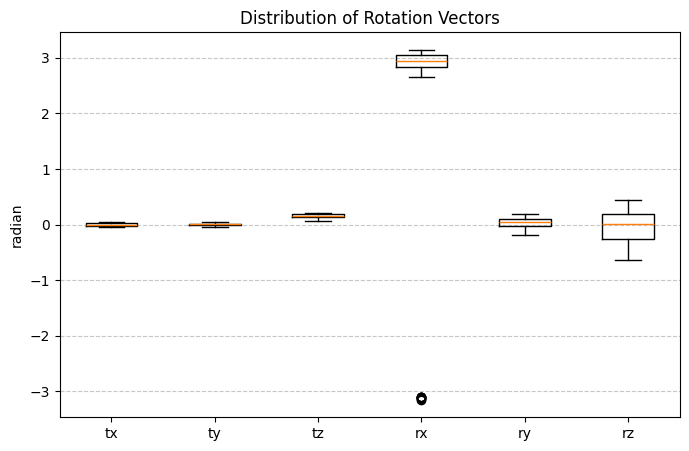

In [51]:
import matplotlib.pyplot as plt
import numpy as np

tx = tvecs[:, 2]
ty = tvecs[:, 3]
tz = tvecs[:, 4]
rx = rvecs[:, 1]
ry = rvecs[:, 2]
rz = rvecs[:, 3]

# boxplot ÏÉùÏÑ±
plt.figure(figsize=(8, 5))
plt.boxplot([tx, ty, tz, rx, ry, rz], labels=['tx', 'ty', 'tz','rx', 'ry', 'rz'])
plt.title('Distribution of Rotation Vectors')
plt.ylabel('radian')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [63]:
eyehand_data = eyehand_data[eyehand_data['rvec_x']>=0]
eyehand_data

count  id    tvec_x    tvec_y    tvec_z    rvec_x    rvec_y    rvec_z  \
0       1   1 -0.009071 -0.000606  0.073760  3.054608  0.049631  0.039036   
1       2   1 -0.005726  0.001014  0.106999  3.016512  0.048868 -0.023966   
4       5   1  0.000163 -0.006364  0.161956  2.971014  0.109770 -0.022231   
7       8   1 -0.003771 -0.003931  0.204059  2.927358  0.070293  0.003258   
10     11   1 -0.048757 -0.015994  0.193320  2.942082 -0.032783  0.431602   
13     14   1  0.038886 -0.017219  0.192659  2.914286  0.146376 -0.462361   
15     16   1  0.051242 -0.008482  0.189107  2.815698  0.122611 -0.587502   
16     17   1  0.037914  0.033154  0.200601  2.649554  0.051620 -0.419924   
17     18   1 -0.049282  0.034936  0.201535  2.709329 -0.003713  0.338995   
18     19   1  0.033233 -0.031868  0.170600  3.127217  0.186053 -0.397740   
24     25   1 -0.047879 -0.030554  0.175897  3.097667 -0.038953  0.402302   
28     29   1 -0.001278 -0.004382  0.121454  3.072767  0.070036 -0.090020   
29     30   1  0.030691  0.005975  0.120610  2.996094  0.137042 -0.397784   
30     31   1 -0.018883  0.003486  0.125065  3.050845  0.030009  0.067318   
32     33   1 -0.025169 -0.015428  0.120033  3.145930  0.022784  0.158397   
35     36   1  0.022402 -0.016416  0.121450  3.091990  0.142079 -0.289910   
36     37   1  0.004644  0.020714  0.153056  2.901807  0.081191 -0.092141   
37     38   1  0.026899  0.024934  0.149790  2.873628  0.106637 -0.318616   
40     41   1 -0.015210 -0.023495  0.147239  3.031795  0.042561  0.102342   
41     42   1 -0.001317 -0.000567  0.107073  3.089431  0.100712 -0.045633   
44     45   1 -0.017255  0.015668  0.193238  2.808029  0.053923  0.110939   
46     47   1  0.031245 -0.006848  0.147804  2.928715  0.105450 -0.397956   
48     49   1  0.037978 -0.022112  0.140961  2.990933  0.141129 -0.411213   
50     51   1 -0.033205 -0.026944  0.148517  3.004178  0.031533  0.253539   
52     53   1 -0.038605  0.010145  0.163734  2.780246  0.025465  0.321164   

        ee_x      ee_y      ee_z       ee_roll  ee_pitch    ee_yaw  
0   0.277307  0.004072  0.179907  4.496213e-19  0.267075  0.015347  
1   0.192238  0.007196  0.204241 -1.314473e-18  0.143072  0.039903  
4   0.047143  0.001835  0.200284  0.000000e+00  0.169576  0.052181  
7  -0.054382 -0.003467  0.187847  2.173978e-18  0.071623  0.052181  
10 -0.046879  0.014941  0.183702 -1.049891e-17  0.131449 -0.248505  
13 -0.045371 -0.019747  0.163725  1.401018e-17  0.137585  0.331502  
15 -0.044492 -0.025785  0.164379 -1.048660e-17  0.122245  0.428190  
16 -0.055633 -0.021095  0.182894 -1.217250e-17 -0.069554  0.302342  
17 -0.056835  0.016794  0.193966 -1.043585e-17 -0.072624 -0.239301  
18 -0.000620 -0.003704  0.199623 -7.494726e-18  0.387552  0.285460  
24 -0.012444  0.005529  0.201729  1.083066e-17  0.280174 -0.222427  
28  0.150085  0.011043  0.202927  3.617884e-18  0.287445  0.079806  
29  0.142686  0.039664  0.210848 -1.432531e-17  0.250614  0.294668  
30  0.143976 -0.004456  0.211918  2.226607e-18  0.229148 -0.033748  
32  0.143790 -0.008097  0.186766  0.000000e+00  0.327387 -0.061359  
35  0.133629  0.027523  0.178634  0.000000e+00  0.325894  0.222536  
36  0.074199  0.009621  0.245631  3.038652e-18  0.043588  0.153473  
37  0.074727  0.019776  0.241140 -5.216829e-18  0.069678  0.305411  
40  0.076236  0.000986  0.158793 -2.222871e-19  0.221827  0.015347  
41  0.183234  0.013166  0.215758 -1.801692e-18  0.273504  0.076737  
44 -0.026243  0.000763  0.205653 -3.659232e-19 -0.005234 -0.019942  
46  0.067670  0.020219  0.178567  1.399261e-17  0.128196  0.348384  
48  0.072933  0.024489  0.157436 -2.128924e-17  0.211091  0.382148  
50  0.067985 -0.007954  0.148558 -5.258335e-18  0.143655 -0.141126  
52  0.044324 -0.004947  0.173080  7.830569e-18 -0.078824 -0.151864

/tmp/ipykernel_6186/3843099572.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tx, ty, tz, rx, ry, rz], labels=['tx', 'ty', 'tz','rx', 'ry', 'rz'])


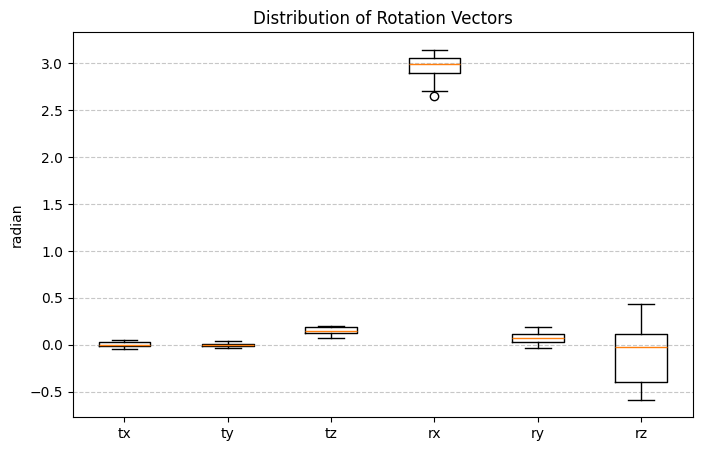

In [65]:
import matplotlib.pyplot as plt
import numpy as np

tx = eyehand_data['tvec_x']
ty = eyehand_data['tvec_y']
tz = eyehand_data['tvec_z']
rx = eyehand_data['rvec_x']
ry = eyehand_data['rvec_y']
rz = eyehand_data['rvec_z']

# boxplot ÏÉùÏÑ±
plt.figure(figsize=(8, 5))
plt.boxplot([tx, ty, tz, rx, ry, rz], labels=['tx', 'ty', 'tz','rx', 'ry', 'rz'])
plt.title('Distribution of Rotation Vectors')
plt.ylabel('radian')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [69]:
eyehand_data.to_csv('t_rvec_ee_list_refined', index=False)